In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
#folder = "/Users/peixuangao/Downloads/0526_backup/data/diff_time/"
folder = "/Users/peixuangao/Downloads/0526_backup/data/10_equal_weight_out_tr/"
#folder = "/Users/peixuangao/Downloads/0526_backup/data/09_diff_weight_out_tr/"
starttime = 0

In [3]:
def read_out_tr(dir, file):
    col = ["events", "time", "from_node", "to_node", "pkt_type", "pkt_size", "flags", "fid", "src_addr", "dst_addr", "seq_num", "pkt_id"]
    df = pd.read_csv(dir+file, sep = ' ', header = None)
    df.columns = col
    return df

In [4]:
def get_receive_packets(df, src_addr):
    df_out = df.loc[df["events"].isin(["r"])]
    df_out = df_out.loc[df_out["pkt_type"].isin(["tcp"])]
    df_out = df_out.loc[df_out["dst_addr"].isin([5.0, 5.1, 5.2, 5.3])]
    df_out = df_out.loc[df_out["to_node"].isin([5])]
    df_out = df_out.loc[df_out["src_addr"].isin(src_addr)]
    return df_out

In [5]:
raw_data_HRCC = read_out_tr(folder, "HRCCPL_out.tr")
raw_data_AFQ10 = read_out_tr(folder, "AFQ10PL_out.tr")
raw_data_AFQ100 = read_out_tr(folder, "AFQ100PL_out.tr")
raw_data_AFQ1000 = read_out_tr(folder, "AFQ1000PL_out.tr")
raw_data_Droptail = read_out_tr(folder, "DropTail_out.tr")
raw_data_AFQ10unlim = read_out_tr(folder, "AFQ10unlimPL_out.tr")

In [6]:
def get_flows(raw_data, microseconds):
    r_event_in_dst_0 = get_receive_packets(raw_data, [0.0, 0.1, 0.2, 0.3])
    r_event_in_dst_1 = get_receive_packets(raw_data, [1.0, 1.1, 1.2, 1.3])
    r_event_in_dst_2 = get_receive_packets(raw_data, [2.0, 2.1, 2.2, 2.3])
    r_event_in_dst_3 = get_receive_packets(raw_data, [3.0, 3.1, 3.2, 3.3])
    
    r_event_in_dst_0['ts'] = r_event_in_dst_0['time'].apply(lambda x: pd.Timedelta(x,unit='s'))
    r_event_in_dst_1['ts'] = r_event_in_dst_1['time'].apply(lambda x: pd.Timedelta(x,unit='s'))
    r_event_in_dst_2['ts'] = r_event_in_dst_2['time'].apply(lambda x: pd.Timedelta(x,unit='s'))
    r_event_in_dst_3['ts'] = r_event_in_dst_3['time'].apply(lambda x: pd.Timedelta(x,unit='s'))
    
    # GB
    shortTh_0 = r_event_in_dst_0[['ts', 'pkt_size']].resample(str(microseconds) + 'U', on='ts').sum()
    shortTh_0['throughtput'] = shortTh_0['pkt_size'] * 8 / (microseconds * 1e-6) / 1000 / 1000 / 1000

    shortTh_1 = r_event_in_dst_1[['ts', 'pkt_size']].resample(str(microseconds) + 'U', on='ts').sum()
    shortTh_1['throughtput'] = shortTh_1['pkt_size'] * 8 / (microseconds * 1e-6) / 1000 / 1000 / 1000

    shortTh_2 = r_event_in_dst_2[['ts', 'pkt_size']].resample(str(microseconds) + 'U', on='ts').sum()
    shortTh_2['throughtput'] = shortTh_2['pkt_size'] * 8 / (microseconds * 1e-6) / 1000 / 1000 / 1000

    shortTh_3 = r_event_in_dst_3[['ts', 'pkt_size']].resample(str(microseconds) + 'U', on='ts').sum()
    shortTh_3['throughtput'] = shortTh_3['pkt_size'] * 8 / (microseconds * 1e-6) / 1000 / 1000 / 1000
    
    res_0 = shortTh_0[['throughtput']].unstack()['throughtput'].T
    res_0.index = res_0.index / timedelta(seconds=1)

    res_1 = shortTh_1[['throughtput']].unstack()['throughtput'].T
    res_1.index = res_1.index / timedelta(seconds=1)

    res_2 = shortTh_2[['throughtput']].unstack()['throughtput'].T
    res_2.index = res_2.index / timedelta(seconds=1)

    res_3 = shortTh_3[['throughtput']].unstack()['throughtput'].T
    res_3.index = res_3.index / timedelta(seconds=1)
    
    # Plot starts
    
    plt.xlabel('time')
    plt.ylabel('throughput (Gbps)')
    plt.title("ShortTh in real time")

    res_0.plot(kind='line', legend=True, title='shortTh', figsize=(6,3), label = 'Flow0')
    res_1.plot(kind='line', legend=True, title='shortTh', figsize=(6,3), label = 'Flow1')
    res_2.plot(kind='line', legend=True, title='shortTh', figsize=(6,3), label = 'Flow2')
    res_3.plot(kind='line', legend=True, title='shortTh', figsize=(6,3), label = 'Flow3')

    ax = plt.gca()
    ax.xaxis.set_ticks_position('bottom')   
    ax.yaxis.set_ticks_position('left') 
    ax.spines['bottom'].set_position(('data', 0))
    ax.spines['left'].set_position(('data', 0))

    plt.show()
    
    # Plot ends
    
    flow0_th = res_0.tolist()
    flow1_th = res_1.tolist()
    flow2_th = res_2.tolist()
    flow3_th = res_3.tolist()
    
    th = [flow0_th, flow1_th, flow2_th, flow3_th]
    
    return th
    
    
    
    

In [7]:
# Function to measure fairness

def measure_fairness(raw_data_0, raw_data_1, raw_data_2, raw_data_3, expected_th, weightlist):
    
    # Find max difference

    merge_short_fairness = pd.DataFrame()

    merge_short_fairness['Short_th_flow0'] = raw_data_0 
    merge_short_fairness['Short_th_flow1'] = raw_data_1 
    merge_short_fairness['Short_th_flow2'] = raw_data_2
    merge_short_fairness['Short_th_flow3'] = raw_data_3
    
    merge_short_fairness['Timestamp'] = merge_short_fairness.index
    #print(merge_short_fairness)

    merge_short_fairness['Max'] = merge_short_fairness.apply(lambda x: max(x['Short_th_flow0'],x['Short_th_flow1'],x['Short_th_flow2'],x['Short_th_flow3']), axis=1)
    merge_short_fairness['Min'] = merge_short_fairness.apply(lambda x: min(x['Short_th_flow0'],x['Short_th_flow1'],x['Short_th_flow2'],x['Short_th_flow3']), axis=1)

    merge_short_fairness['Short_fairness'] = merge_short_fairness.apply(lambda x: (x['Max']-x['Min'])/expected_th, axis=1)

    average_fairness = merge_short_fairness['Short_fairness'].mean()
    
    return average_fairness

In [87]:
window_size = 24 # microsecond

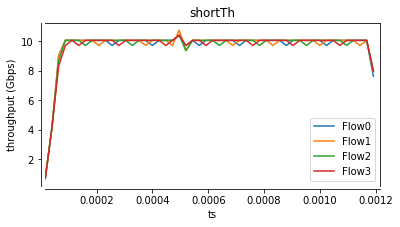

In [88]:
flows_HRCC = get_flows(raw_data_HRCC, window_size)
#measure_fairness(flow0_th, flow1_th, flow2_th, flow3_th, 10, [1,1,1,1])

In [89]:
measure_fairness(flows_HRCC[0], flows_HRCC[1], flows_HRCC[2], flows_HRCC[3], 10, [1,1,1,1])

0.022186666666666813

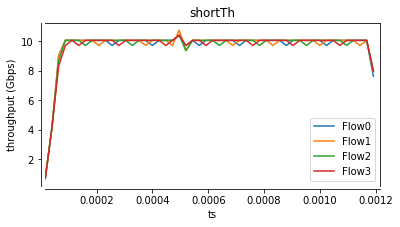

0.022186666666666813

In [90]:
flows_HRCC = get_flows(raw_data_HRCC, window_size)
measure_fairness(flows_HRCC[0], flows_HRCC[1], flows_HRCC[2], flows_HRCC[3], 10, [1,1,1,1])

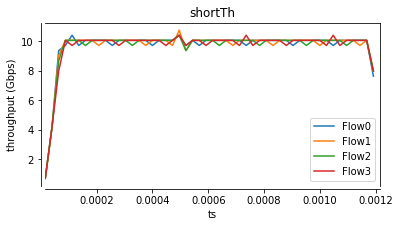

0.027733333333333478

In [91]:
flows_AFQ10unlim = get_flows(raw_data_AFQ10unlim, window_size)
measure_fairness(flows_AFQ10unlim[0], flows_AFQ10unlim[1], flows_AFQ10unlim[2], flows_AFQ10unlim[3], 10, [1,1,1,1])

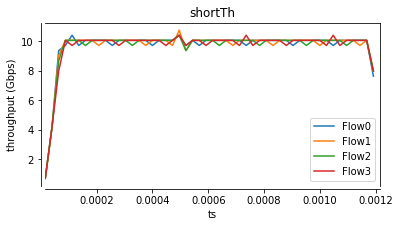

0.027733333333333478

In [92]:
flows_AFQ10 = get_flows(raw_data_AFQ10, window_size)
measure_fairness(flows_AFQ10[0], flows_AFQ10[1], flows_AFQ10[2], flows_AFQ10[3], 10, [1,1,1,1])

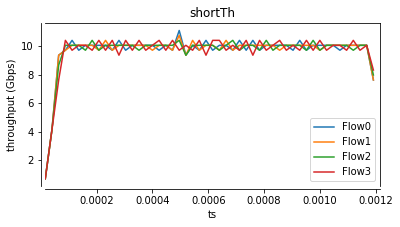

0.06032000000000018

In [93]:
flows_AFQ100 = get_flows(raw_data_AFQ100, window_size)
measure_fairness(flows_AFQ100[0], flows_AFQ100[1], flows_AFQ100[2], flows_AFQ100[3], 10, [1,1,1,1])

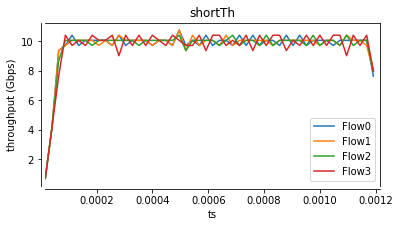

0.0630933333333335

In [94]:
flows_AFQ1000 = get_flows(raw_data_AFQ1000, window_size)
measure_fairness(flows_AFQ1000[0], flows_AFQ1000[1], flows_AFQ1000[2], flows_AFQ1000[3], 10, [1,1,1,1])

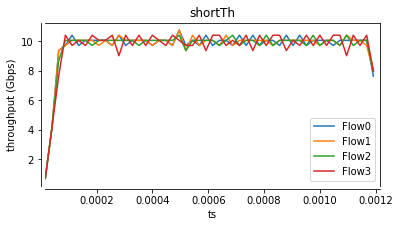

0.0630933333333335

In [95]:
flows_Droptail = get_flows(raw_data_Droptail, window_size)
measure_fairness(flows_Droptail[0], flows_Droptail[1], flows_Droptail[2], flows_Droptail[3], 10, [1,1,1,1])

In [96]:
# [HRCC, PIFO, AFQ10, AFQ100, AFQ1000, Droptail]
fairness_10us = [0.024266666666666683, 0.05200000000000005, 0.05200000000000005, 0.11231999999999995, 0.17125333333333323, 0.17125333333333323]

fairness_12us = [0.07002666666666695, 0.06864000000000027, 0.06864000000000027, 0.0908266666666668, 0.10885333333333339, 0.10885333333333339]

fairness_6us = [0.12036548223350244, 0.06864000000000027, 0.06864000000000027, 0.0908266666666668, 0.10885333333333339, 0.10885333333333339]


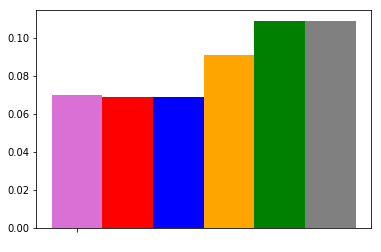

In [97]:
fairness = fairness_12us

delay_hrcc_part = fairness[0]
delay_afq10unlim_part = fairness[1]
delay_afq10_part = fairness[2]
delay_afq100_part = fairness[3]
delay_afq1000_part = fairness[4]
delay_droptail_part = fairness[5]


name_list = [' ']
x = list(range(len(name_list)))
total_width, n = 0.8, 6
#width = total_width / n
width = (total_width / n)*0.8
plt.bar(x, delay_hrcc_part, width=width, label='Gearbox', tick_label=name_list, fc='orchid')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, delay_afq10unlim_part, width=width, label='PIFO', fc='red')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, delay_afq10_part, width=width, label='AFQ10', fc='blue')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, delay_afq100_part, width=width, label='AFQ100', fc='orange')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, delay_afq1000_part, width=width, label='AFQ1000', fc='green')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, delay_droptail_part, width=width, label='DropTail', fc='grey')
#plt.legend()
plt.show()

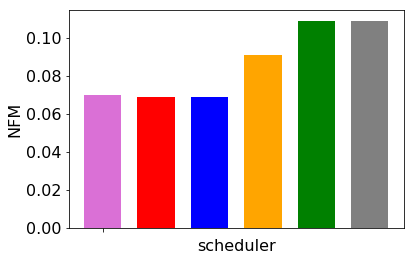

In [43]:
fairness = fairness_12us

delay_hrcc_part = fairness[0]
delay_afq10unlim_part = fairness[1]
delay_afq10_part = fairness[2]
delay_afq100_part = fairness[3]
delay_afq1000_part = fairness[4]
delay_droptail_part = fairness[5]


name_list = ['']
x = list(range(len(name_list)))
total_width, n = 0.8, 6
width = total_width / n
#width = (total_width / n)*0.8
plt.bar(x, delay_hrcc_part, width=width*0.7, label='Gearbox', tick_label=name_list, fc='orchid')

for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, delay_afq10unlim_part, width=width*0.7, label='PIFO', fc='red')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, delay_afq10_part, width=width*0.7, label='AFQ10', fc='blue')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, delay_afq100_part, width=width*0.7, label='AFQ100', fc='orange')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, delay_afq1000_part, width=width*0.7, label='AFQ1000', fc='green')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, delay_droptail_part, width=width*0.7, label='DropTail', fc='grey')

plt.xlabel('scheduler', fontsize = 16)
plt.ylabel('NFM', fontsize = 16)
plt.tick_params(labelsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

#plt.legend()
plt.show()

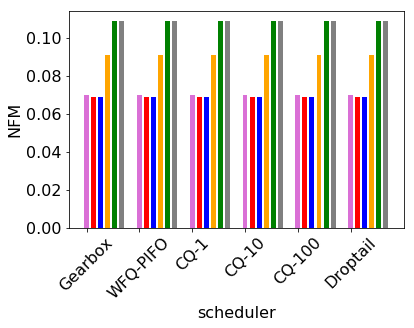

In [47]:
fairness = fairness_12us

delay_hrcc_part = fairness[0]
delay_afq10unlim_part = fairness[1]
delay_afq10_part = fairness[2]
delay_afq100_part = fairness[3]
delay_afq1000_part = fairness[4]
delay_droptail_part = fairness[5]


name_list = ['Gearbox', 'WFQ-PIFO', 'CQ-1', 'CQ-10', 'CQ-100', 'Droptail']
x = list(range(len(name_list)))
total_width, n = 0.8, 6
width = total_width / n
#width = (total_width / n)*0.8
plt.bar(x, delay_hrcc_part, width=width*0.7, label='Gearbox', tick_label=name_list, fc='orchid')

for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, delay_afq10unlim_part, width=width*0.7, label='PIFO', fc='red')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, delay_afq10_part, width=width*0.7, label='AFQ10', fc='blue')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, delay_afq100_part, width=width*0.7, label='AFQ100', fc='orange')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, delay_afq1000_part, width=width*0.7, label='AFQ1000', fc='green')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, delay_droptail_part, width=width*0.7, label='DropTail', fc='grey')

plt.xlabel('scheduler', fontsize = 16)
plt.ylabel('NFM', fontsize = 16)
plt.tick_params(labelsize = 16)
plt.xticks(fontsize = 16, rotation=45)
plt.yticks(fontsize = 16)

#plt.legend()
plt.show()